# Evaluación Parcial 1 - Machine Learning
## Proyecto: Predicción y Preparación de Pandemias
### Notebook 2: COMPRENSIÓN DE LOS DATOS (Data Understanding)

---

**Fase 2 CRISP-DM**: Data Understanding

**Integrantes**: [Escribe aquí los nombres del equipo]

**Fecha**: Noviembre 2025

**Asignatura**: Machine Learning (MLY0100)

---

## 📋 Objetivos de este Notebook

Este notebook implementa la **Fase 2 de CRISP-DM: Comprensión de los Datos**, con los siguientes objetivos:

1. **Recolectar datos iniciales**: Cargar los 4 datasets desde el catálogo de Kedro
2. **Describir los datos**: Analizar estructura, tipos, dimensiones
3. **Explorar los datos**: EDA exhaustivo (univariado, bivariado, multivariado)
4. **Verificar calidad**: Identificar missing values, outliers, inconsistencias
5. **Análisis temporal**: Evolución de la pandemia y vacunación
6. **Análisis geográfico**: Cobertura por países
7. **Correlaciones**: Identificar relaciones entre variables
8. **Conclusiones**: Hallazgos principales para la preparación de datos

---

## 1️⃣ SETUP: Configuración del Entorno Kedro

In [5]:
# Cargar extensión de Kedro para Jupyter
%load_ext kedro.ipython

print("✅ Extensión Kedro cargada correctamente")
print("📊 Ahora podemos acceder al catálogo de datos con: catalog.load('nombre_dataset')")

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython
✅ Extensión Kedro cargada correctamente
📊 Ahora podemos acceder al catálogo de datos con: catalog.load('nombre_dataset')


In [6]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from datetime import datetime
import scipy.stats as stats

# Configuraciones
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

print("✅ Librerías importadas correctamente")
print(f"📦 Pandas version: {pd.__version__}")
print(f"📦 NumPy version: {np.__version__}")

✅ Librerías importadas correctamente
📦 Pandas version: 2.3.3
📦 NumPy version: 2.3.5


In [7]:
# Verificar contexto de Kedro
print("="*70)
print("🔍 VERIFICACIÓN DEL PROYECTO KEDRO")
print("="*70)

# Información del proyecto
print(f"\n📁 Ruta del proyecto: {context.project_path}")

# Obtener nombre del paquete de forma compatible
try:
    # Intentar método moderno (Kedro 0.18+)
    package_name = context.package_name
except AttributeError:
    # Fallback para versiones anteriores
    try:
        package_name = context._package_name
    except AttributeError:
        # Último recurso: extraer del path
        import os
        src_path = context.project_path / "src"
        if src_path.exists():
            packages = [d for d in os.listdir(src_path) 
                       if os.path.isdir(src_path / d) and not d.startswith('_')]
            package_name = packages[0] if packages else "desconocido"
        else:
            package_name = "desconocido"

print(f"📦 Nombre del paquete: {package_name}")

# Información del catálogo
print(f"\n📊 Datasets disponibles en el catálogo:")
print("="*70)

# Listar todos los datasets
try:
    all_datasets = sorted(catalog.list())
    print(f"\n📋 Todos los datasets ({len(all_datasets)}):")
    for i, dataset in enumerate(all_datasets, 1):
        print(f"  {i:2d}. {dataset}")
    
    # Filtrar solo los raw
    raw_datasets = [ds for ds in all_datasets if 'raw' in ds.lower()]
    print(f"\n🔍 Datasets RAW ({len(raw_datasets)}):")
    for i, dataset in enumerate(raw_datasets, 1):
        print(f"  {i}. {dataset}")
    
    print(f"\n✅ Total de datasets raw disponibles: {len(raw_datasets)}")
    print(f"✅ Total de datasets en el catálogo: {len(all_datasets)}")
    
except Exception as e:
    print(f"⚠️ Error al listar datasets: {e}")
    print("💡 Sugerencia: Verifica que catalog.yml esté correctamente configurado")

🔍 VERIFICACIÓN DEL PROYECTO KEDRO

📁 Ruta del proyecto: D:\Maching\prediccion-pandemias\prediccion-preparacion-pandemias
📦 Nombre del paquete: prediccion_preparacion_pandemias

📊 Datasets disponibles en el catálogo:

📋 Todos los datasets (55):
   1. covid_data_cleaned
   2. covid_data_raw
   3. covid_data_validated
   4. master_dataset
   5. model_input_classification
   6. model_input_regression
   7. parameters
   8. params:cleaning
   9. params:cleaning.categorical_imputation
  10. params:cleaning.categorical_imputation.strategy
  11. params:cleaning.date_columns
  12. params:cleaning.epidemiological_vars
  13. params:cleaning.epidemiological_vars.imputation
  14. params:cleaning.numeric_imputation
  15. params:cleaning.numeric_imputation.strategy
  16. params:cleaning.socioeconomic_vars
  17. params:cleaning.socioeconomic_vars.imputation
  18. params:data_quality
  19. params:data_quality.min_records_per_country
  20. params:data_quality.missing_threshold
  21. params:data_quality.

---
## 2️⃣ CARGA DE DATOS: Recolección Inicial

In [8]:
print("="*70)
print("📂 CARGANDO DATASETS DESDE EL CATÁLOGO DE KEDRO")
print("="*70)

# Cargar datasets usando el catálogo de Kedro
print("\n1️⃣ Cargando COVID-19 Data...")
covid_raw = catalog.load("covid_data_raw")
print(f"   ✅ COVID-19: {covid_raw.shape[0]:,} registros × {covid_raw.shape[1]} columnas")

print("\n2️⃣ Cargando Vaccination Global Data...")
vaccination_global = catalog.load("vaccination_global_raw")
print(f"   ✅ Vacunación Global: {vaccination_global.shape[0]:,} registros × {vaccination_global.shape[1]} columnas")

print("\n3️⃣ Cargando Vaccination by Age Data...")
vaccination_age = catalog.load("vaccination_age_raw")
print(f"   ✅ Vacunación por Edad: {vaccination_age.shape[0]:,} registros × {vaccination_age.shape[1]} columnas")

print("\n4️⃣ Cargando Vaccination by Manufacturer Data...")
vaccination_manuf = catalog.load("vaccination_manufacturer_raw")
print(f"   ✅ Vacunación por Fabricante: {vaccination_manuf.shape[0]:,} registros × {vaccination_manuf.shape[1]} columnas")

print("\n" + "="*70)
print("✅ TODOS LOS DATASETS CARGADOS CORRECTAMENTE")
print("="*70)
print(f"\n📊 Total de registros: {covid_raw.shape[0] + vaccination_global.shape[0] + vaccination_age.shape[0] + vaccination_manuf.shape[0]:,}")
print(f"📊 Total de columnas: {covid_raw.shape[1] + vaccination_global.shape[1] + vaccination_age.shape[1] + vaccination_manuf.shape[1]}")

📂 CARGANDO DATASETS DESDE EL CATÁLOGO DE KEDRO

1️⃣ Cargando COVID-19 Data...


[11/23/25 16:51:58] INFO     Loading data from 'covid_data_raw' (CSVDataset)...                 ]8;id=603244;file://D:\Maching\prediccion-pandemias\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=869758;file://D:\Maching\prediccion-pandemias\venv\Lib\site-packages\kedro\io\data_catalog.py#502\502]8;;\

   ✅ COVID-19: 521,908 registros × 61 columnas

2️⃣ Cargando Vaccination Global Data...


[11/23/25 16:52:00] INFO     Loading data from 'vaccination_global_raw' (CSVDataset)...         ]8;id=141024;file://D:\Maching\prediccion-pandemias\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=971515;file://D:\Maching\prediccion-pandemias\venv\Lib\site-packages\kedro\io\data_catalog.py#502\502]8;;\

   ✅ Vacunación Global: 203,057 registros × 29 columnas

3️⃣ Cargando Vaccination by Age Data...


[11/23/25 16:52:01] INFO     Loading data from 'vaccination_age_raw' (CSVDataset)...            ]8;id=448351;file://D:\Maching\prediccion-pandemias\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=212116;file://D:\Maching\prediccion-pandemias\venv\Lib\site-packages\kedro\io\data_catalog.py#502\502]8;;\

   ✅ Vacunación por Edad: 74,142 registros × 6 columnas

4️⃣ Cargando Vaccination by Manufacturer Data...


                    INFO     Loading data from 'vaccination_manufacturer_raw' (CSVDataset)...   ]8;id=709121;file://D:\Maching\prediccion-pandemias\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=998964;file://D:\Maching\prediccion-pandemias\venv\Lib\site-packages\kedro\io\data_catalog.py#502\502]8;;\

   ✅ Vacunación por Fabricante: 888,360 registros × 4 columnas

✅ TODOS LOS DATASETS CARGADOS CORRECTAMENTE

📊 Total de registros: 1,687,467
📊 Total de columnas: 100


---
## 3️⃣ ANÁLISIS BÁSICO: Descripción de los Datos

### 3.1 Dataset 1: COVID-19 Compact Data

In [9]:
print("="*70)
print("📊 ANÁLISIS: COVID-19 DATASET")
print("="*70)

print(f"\n📌 Dimensiones: {covid_raw.shape[0]:,} registros × {covid_raw.shape[1]} columnas")

# Convertir fecha si es necesario
if 'date' in covid_raw.columns:
    covid_raw['date'] = pd.to_datetime(covid_raw['date'], errors='coerce')
    print(f"\n📅 Período temporal:")
    print(f"   - Inicio: {covid_raw['date'].min()}")
    print(f"   - Fin: {covid_raw['date'].max()}")
    print(f"   - Duración: {(covid_raw['date'].max() - covid_raw['date'].min()).days} días")

if 'location' in covid_raw.columns:
    print(f"\n🌍 Cobertura geográfica: {covid_raw['location'].nunique()} países/regiones")
    print(f"\n   Top 10 países por registros:")
    top_countries = covid_raw['location'].value_counts().head(10)
    for i, (country, count) in enumerate(top_countries.items(), 1):
        print(f"      {i:2d}. {country:30s}: {count:,} registros")

print(f"\n📋 Columnas del dataset ({len(covid_raw.columns)}):")
for i, col in enumerate(covid_raw.columns, 1):
    dtype = covid_raw[col].dtype
    print(f"   {i:2d}. {col:40s} ({dtype})")

📊 ANÁLISIS: COVID-19 DATASET

📌 Dimensiones: 521,908 registros × 61 columnas

📅 Período temporal:
   - Inicio: 2020-01-01 00:00:00
   - Fin: 2025-12-31 00:00:00
   - Duración: 2191 días

📋 Columnas del dataset (61):
    1. country                                  (object)
    2. date                                     (datetime64[ns])
    3. total_cases                              (float64)
    4. new_cases                                (float64)
    5. new_cases_smoothed                       (float64)
    6. total_cases_per_million                  (float64)
    7. new_cases_per_million                    (float64)
    8. new_cases_smoothed_per_million           (float64)
    9. total_deaths                             (float64)
   10. new_deaths                               (float64)
   11. new_deaths_smoothed                      (float64)
   12. total_deaths_per_million                 (float64)
   13. new_deaths_per_million                   (float64)
   14. new_deaths_smooth

In [10]:
# Primeras filas
print("\n🔍 Primeras 5 filas del dataset COVID-19:")
print("="*70)
display(covid_raw.head())


🔍 Primeras 5 filas del dataset COVID-19:


,country,date,total_cases,new_cases,new_cases_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths,new_deaths,new_deaths_smoothed,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,excess_mortality,excess_mortality_cumulative,excess_mortality_cumulative_absolute,excess_mortality_cumulative_per_million,hosp_patients,hosp_patients_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,icu_patients,icu_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,stringency_index,reproduction_rate,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,code,continent,population,population_density,median_age,life_expectancy,gdp_per_capita,extreme_poverty,diabetes_prevalence,handwashing_facilities,hospital_beds_per_thousand,human_development_index
0,Afghanistan,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AFG,Asia,40578801.000,62.215,16.752,65.617,1516.273,NaN,10.900,48.215,0.390,NaN
1,Afghanistan,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AFG,Asia,40578801.000,62.215,16.752,65.617,1516.273,NaN,10.900,48.215,0.390,NaN
2,Afghanistan,2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AFG,Asia,40578801.000,62.215,16.752,65.617,1516.273,NaN,10.900,48.215,0.390,NaN
3,Afghanistan,2020-01-04,0.000,0.000,NaN,0.000,0.000,NaN,0.000,0.000,NaN,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AFG,Asia,40578801.000,62.215,16.752,65.617,1516.273,NaN,10.900,48.215,0.390,NaN
4,Afghanistan,2020-01-05,0.000,0.000,NaN,0.000,0.000,NaN,0.000,0.000,NaN,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AFG,Asia,40578801.000,62.215,16.752,65.617,1516.273,NaN,10.900,48.215,0.390,NaN


In [11]:
# Información general
print("\n📊 Información general del dataset:")
print("="*70)
print(covid_raw.info())


📊 Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521908 entries, 0 to 521907
Data columns (total 61 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   country                                     521908 non-null  object        
 1   date                                        521908 non-null  datetime64[ns]
 2   total_cases                                 507711 non-null  float64       
 3   new_cases                                   504569 non-null  float64       
 4   new_cases_smoothed                          503364 non-null  float64       
 5   total_cases_per_million                     507711 non-null  float64       
 6   new_cases_per_million                       504569 non-null  float64       
 7   new_cases_smoothed_per_million              503364 non-null  float64       
 8   total_deaths                          

In [12]:
# Estadísticas descriptivas
print("\n📈 Estadísticas descriptivas - Variables numéricas:")
print("="*70)
display(covid_raw.describe())


📈 Estadísticas descriptivas - Variables numéricas:


,date,total_cases,new_cases,new_cases_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths,new_deaths,new_deaths_smoothed,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,excess_mortality,excess_mortality_cumulative,excess_mortality_cumulative_absolute,excess_mortality_cumulative_per_million,hosp_patients,hosp_patients_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,icu_patients,icu_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,stringency_index,reproduction_rate,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,population,population_density,median_age,life_expectancy,gdp_per_capita,extreme_poverty,diabetes_prevalence,handwashing_facilities,hospital_beds_per_thousand,human_development_index
count,521908,507711.000,504569.000,503364.000,507711.000,504569.000,503364.000,507711.000,505405.000,504193.000,507711.000,505405.000,504193.000,13636.000,13636.000,13636.000,13602.000,40656.000,40656.000,24497.000,24497.000,39116.000,39116.000,10993.000,10993.000,202760.000,185683.000,79387.000,75403.000,79387.000,75403.000,103965.000,103965.000,101560.000,100645.000,83222.000,79011.000,77011.000,58784.000,68876.000,202840.000,83222.000,79011.000,77011.000,58784.000,202840.000,202840.000,202840.000,504985.000,496821.000,498868.000,500907.000,407552.000,334500.000,440239.000,236221.000,315648.000,0.000
mean,2022-10-14 20:41:02.778880512,13987924.072,10768.028,10793.832,128757.843,101.036,101.281,153326.453,102.891,103.141,915.851,0.630,0.631,10.894,9.798,55426.693,1784.713,3911.742,125.988,4291.723,82.619,660.971,15.656,317.894,9.672,42.675,0.908,21104573.938,67285.412,924.255,3.272,142178.364,2.826,10.419,1833.139,583668210.552,264073436.348,243008602.276,143055472.494,766639.989,275096.280,121.560,52.672,47.265,31.140,1729.315,100136.152,0.069,131384852.487,381.376,31.184,73.459,22536.502,14.414,9.057,59.258,3.184,NaN
min,2020-01-01 00:00:00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-95.921,-44.228,-37726.100,-2918.806,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.069,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,501.000,0.136,14.298,18.818,708.178,0.000,1.100,3.440,0.300,NaN
25%,2021-05-24 00:00:00,9000.000,0.000,0.000,2973.169,0.000,0.000,67.000,0.000,0.000,37.044,0.000,0.000,-1.502,2.174,184.850,127.344,186.000,30.997,223.000,23.728,21.000,2.328,17.000,1.549,22.220,0.713,364654.000,2244.000,43.585,0.286,1486.000,0.203,1.610,6.832,1893255.750,1011266.500,862647.500,385287.000,1784.000,216.000,43.015,26.794,19.478,2.032,97.101,19.429,0.001,455326.000,36.266,22.244,68.749,5155.620,0.497,5.600,26.200,1.320,NaN
50%,2022-10-10 00:00:00,82497.000,0.000,5.286,45142.023,0.000,0.966,1016.000,0.000,0.000,375.667,0.000,0.000,5.624,8.236,6625.198,1305.706,776.000,74.236,864.000,56.277,90.000,6.434,92.000,4.645,42.590,0.948,2067330.000,8783.000,234.141,0.971,6570.000,0.851,5.489,17.596,15740619.500,6979643.000,6800994.000,6124202.500,22055.500,3249.886,126.998,63.224,56.599,27.944,513.054,566.034,0.010,6035057.000,92.081,31.683,74.696,14740.010,2.817,7.400,70.154,2.600,NaN
75%,2024-03-05 00:00:00,1062275.000,69.000,208.714,190199.940,8.149,34.094,12198.500,0.000,2.000,1433.366,0.000,0.209,15.533,15.178,38879.350,2873.286,3051.000,159.758,3893.000,109.998,413.000,18.779,353.000,12.651,62.040,1.136,10248451.500,37229.000,894.375,2.914,32205.000,2.584,14.268,58

### 3.2 Dataset 2: Vaccination Global Data

In [13]:
print("="*70)
print("📊 ANÁLISIS: VACCINATION GLOBAL DATASET")
print("="*70)

print(f"\n📌 Dimensiones: {vaccination_global.shape[0]:,} registros × {vaccination_global.shape[1]} columnas")

if 'date' in vaccination_global.columns:
    vaccination_global['date'] = pd.to_datetime(vaccination_global['date'], errors='coerce')
    print(f"\n📅 Período temporal:")
    print(f"   - Inicio: {vaccination_global['date'].min()}")
    print(f"   - Fin: {vaccination_global['date'].max()}")
    print(f"   - Duración: {(vaccination_global['date'].max() - vaccination_global['date'].min()).days} días")

if 'location' in vaccination_global.columns:
    print(f"\n🌍 Cobertura geográfica: {vaccination_global['location'].nunique()} países/regiones")

print(f"\n📋 Columnas del dataset ({len(vaccination_global.columns)}):")
for i, col in enumerate(vaccination_global.columns, 1):
    dtype = vaccination_global[col].dtype
    print(f"   {i:2d}. {col:40s} ({dtype})")

print("\n🔍 Primeras 5 filas:")
display(vaccination_global.head())

📊 ANÁLISIS: VACCINATION GLOBAL DATASET

📌 Dimensiones: 203,057 registros × 29 columnas

📅 Período temporal:
   - Inicio: 2020-12-02 00:00:00
   - Fin: 2024-08-12 00:00:00
   - Duración: 1349 días

📋 Columnas del dataset (29):
    1. country                                  (object)
    2. date                                     (datetime64[ns])
    3. total_vaccinations                       (float64)
    4. people_vaccinated                        (float64)
    5. people_fully_vaccinated                  (float64)
    6. total_boosters                           (float64)
    7. daily_vaccinations                       (float64)
    8. daily_vaccinations_smoothed              (float64)
    9. daily_people_vaccinated_smoothed         (float64)
   10. total_vaccinations_per_hundred           (float64)
   11. people_vaccinated_per_hundred            (float64)
   12. people_fully_vaccinated_per_hundred      (float64)
   13. total_boosters_per_hundred               (float64)
   14. daily_p

,country,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations,daily_vaccinations_smoothed,daily_people_vaccinated_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_people_vaccinated_smoothed_per_hundred,daily_vaccinations_smoothed_per_million,people_unvaccinated,share_of_boosters,total_vaccinations_interpolated,people_vaccinated_interpolated,people_fully_vaccinated_interpolated,total_boosters_interpolated,total_vaccinations_no_boosters_interpolated,total_vaccinations_no_boosters_per_hundred_interpolated,rolling_vaccinations_6m,rolling_vaccinations_6m_per_hundred,rolling_vaccinations_9m,rolling_vaccinations_9m_per_hundred,rolling_vaccinations_12m,rolling_vaccinations_12m_per_hundred
0,Afghanistan,2021-02-22,0.000,0.000,NaN,NaN,NaN,NaN,NaN,0.000,0.000,NaN,NaN,NaN,NaN,39671170.732,NaN,0.000,0.000,55624.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,2021-02-23,NaN,NaN,NaN,NaN,NaN,1366.667,1366.667,NaN,NaN,NaN,NaN,0.003,33.679,NaN,NaN,1366.667,1366.667,55624.000,0.000,1366.667,NaN,1366.667,0.003,1366.667,0.003,1366.667,0.003
2,Afghanistan,2021-02-24,NaN,NaN,NaN,NaN,NaN,1366.667,1366.667,NaN,NaN,NaN,NaN,0.003,33.679,NaN,NaN,2733.333,2733.333,55624.000,0.000,2733.333,NaN,2733.333,0.007,2733.333,0.007,2733.333,0.007
3,Afghanistan,2021-02-25,NaN,NaN,NaN,NaN,NaN,1366.667,1366.667,NaN,NaN,NaN,NaN,0.003,33.679,NaN,NaN,4100.000,4100.000,55624.000,0.000,4100.000,NaN,4100.000,0.010,4100.000,0.010,4100.000,0.010
4,Afghanistan,2021-02-26,NaN,NaN,NaN,NaN,NaN,1366.667,1366.667,NaN,NaN,NaN,NaN,0.003,33.679,NaN,NaN,5466.667,5466.667,55624.000,0.000,5466.667,NaN,5466.667,0.013,5466.667,0.013,5466.667,0.013


### 3.3 Dataset 3: Vaccination by Age

In [14]:
print("="*70)
print("📊 ANÁLISIS: VACCINATION BY AGE DATASET")
print("="*70)

print(f"\n📌 Dimensiones: {vaccination_age.shape[0]:,} registros × {vaccination_age.shape[1]} columnas")

if 'date' in vaccination_age.columns:
    vaccination_age['date'] = pd.to_datetime(vaccination_age['date'], errors='coerce')

print(f"\n📋 Columnas: {list(vaccination_age.columns)}")

print("\n🔍 Primeras 5 filas:")
display(vaccination_age.head())

📊 ANÁLISIS: VACCINATION BY AGE DATASET

📌 Dimensiones: 74,142 registros × 6 columnas

📋 Columnas: ['country', 'age_group', 'date', 'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred', 'people_with_booster_per_hundred']

🔍 Primeras 5 filas:


,country,age_group,date,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,people_with_booster_per_hundred
0,Argentina,100+,2020-01-01,0.000,0.000,0.000
1,Argentina,100+,2020-01-02,0.000,0.000,0.000
2,Argentina,100+,2020-01-03,0.000,0.000,0.000
3,Argentina,100+,2020-01-04,0.000,0.000,0.000
4,Argentina,100+,2020-01-05,0.000,0.000,0.000


### 3.4 Dataset 4: Vaccination by Manufacturer

In [15]:
print("="*70)
print("📊 ANÁLISIS: VACCINATION BY MANUFACTURER DATASET")
print("="*70)

print(f"\n📌 Dimensiones: {vaccination_manuf.shape[0]:,} registros × {vaccination_manuf.shape[1]} columnas")

if 'date' in vaccination_manuf.columns:
    vaccination_manuf['date'] = pd.to_datetime(vaccination_manuf['date'], errors='coerce')

print(f"\n📋 Columnas: {list(vaccination_manuf.columns)}")

print("\n🔍 Primeras 5 filas:")
display(vaccination_manuf.head())

📊 ANÁLISIS: VACCINATION BY MANUFACTURER DATASET

📌 Dimensiones: 888,360 registros × 4 columnas

📋 Columnas: ['country', 'vaccine', 'date', 'total_vaccinations']

🔍 Primeras 5 filas:


,country,vaccine,date,total_vaccinations
0,Argentina,CanSino,2020-12-04,1
1,Argentina,CanSino,2020-12-05,1
2,Argentina,CanSino,2020-12-06,1
3,Argentina,CanSino,2020-12-07,1
4,Argentina,CanSino,2020-12-08,1


---
## 4️⃣ ANÁLISIS DE CALIDAD: Missing Values y Datos Faltantes

In [16]:
def analyze_missing_values(df, dataset_name):
    """
    Analiza missing values de forma exhaustiva.
    
    Args:
        df: DataFrame a analizar
        dataset_name: Nombre del dataset para el reporte
    
    Returns:
        DataFrame con análisis de missing values
    """
    print("\n" + "="*70)
    print(f"🔍 ANÁLISIS DE MISSING VALUES: {dataset_name}")
    print("="*70)
    
    # Calcular missing values
    missing = df.isnull().sum()
    missing_pct = (missing / len(df) * 100).round(2)
    
    # Crear DataFrame de análisis
    missing_df = pd.DataFrame({
        'Columna': missing.index,
        'Missing_Count': missing.values,
        'Missing_Pct': missing_pct.values,
        'Dtype': df.dtypes.values
    })
    
    # Filtrar solo columnas con missing
    missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values(
        'Missing_Pct', ascending=False
    )
    
    # Resumen
    print(f"\n📊 Resumen:")
    print(f"   - Total de columnas: {len(df.columns)}")
    print(f"   - Columnas con missing: {len(missing_df)}")
    print(f"   - Columnas completas: {len(df.columns) - len(missing_df)}")
    print(f"   - Total de celdas: {df.shape[0] * df.shape[1]:,}")
    print(f"   - Celdas con missing: {missing.sum():,}")
    print(f"   - % Missing global: {(missing.sum() / (df.shape[0] * df.shape[1]) * 100):.2f}%")
    
    if len(missing_df) > 0:
        print(f"\n📋 Top 15 columnas con más missing values:")
        print("="*70)
        display(missing_df.head(15))
        
        # Categorizar por severidad
        critical = len(missing_df[missing_df['Missing_Pct'] > 70])
        high = len(missing_df[(missing_df['Missing_Pct'] > 50) & (missing_df['Missing_Pct'] <= 70)])
        medium = len(missing_df[(missing_df['Missing_Pct'] > 30) & (missing_df['Missing_Pct'] <= 50)])
        low = len(missing_df[missing_df['Missing_Pct'] <= 30])
        
        print(f"\n⚠️ Categorización por severidad:")
        print(f"   🔴 Crítico (>70% missing): {critical} columnas")
        print(f"   🟠 Alto (50-70% missing): {high} columnas")
        print(f"   🟡 Medio (30-50% missing): {medium} columnas")
        print(f"   🟢 Bajo (<30% missing): {low} columnas")
    else:
        print("\n✅ ¡No hay missing values en este dataset!")
    
    return missing_df

In [17]:
# Analizar missing values en cada dataset
covid_missing = analyze_missing_values(covid_raw, "COVID-19")
vacc_missing = analyze_missing_values(vaccination_global, "Vaccination Global")
age_missing = analyze_missing_values(vaccination_age, "Vaccination by Age")
manuf_missing = analyze_missing_values(vaccination_manuf, "Vaccination by Manufacturer")


🔍 ANÁLISIS DE MISSING VALUES: COVID-19

📊 Resumen:
   - Total de columnas: 61
   - Columnas con missing: 59
   - Columnas completas: 2
   - Total de celdas: 31,836,388
   - Celdas con missing: 17,139,945
   - % Missing global: 53.84%

📋 Top 15 columnas con más missing values:


,Columna,Missing_Count,Missing_Pct,Dtype
60,human_development_index,521908,100.000,float64
24,weekly_icu_admissions,510915,97.890,float64
25,weekly_icu_admissions_per_million,510915,97.890,float64
15,excess_mortality_cumulative,508272,97.390,float64
16,excess_mortality_cumulative_absolute,508272,97.390,float64
17,excess_mortality_cumulative_per_million,508306,97.390,float64
14,excess_mortality,508272,97.390,float64
21,weekly_hosp_admissions_per_million,497411,95.310,float64
20,weekly_hosp_admissions,497411,95.310,float64
22,icu_patients,482792,92.510,float64



⚠️ Categorización por severidad:
   🔴 Crítico (>70% missing): 30 columnas
   🟠 Alto (50-70% missing): 7 columnas
   🟡 Medio (30-50% missing): 2 columnas
   🟢 Bajo (<30% missing): 20 columnas

🔍 ANÁLISIS DE MISSING VALUES: Vaccination Global

📊 Resumen:
   - Total de columnas: 29
   - Columnas con missing: 22
   - Columnas completas: 7
   - Total de celdas: 5,888,653
   - Celdas con missing: 1,635,246
   - % Missing global: 27.77%

📋 Top 15 columnas con más missing values:


,Columna,Missing_Count,Missing_Pct,Dtype
16,share_of_boosters,201721,99.340,float64
22,total_vaccinations_no_boosters_per_hundred_int...,144728,71.270,float64
5,total_boosters,144273,71.050,float64
12,total_boosters_per_hundred,144273,71.050,float64
6,daily_vaccinations,134181,66.080,float64
4,people_fully_vaccinated,126046,62.070,float64
11,people_fully_vaccinated_per_hundred,126046,62.070,float64
15,people_unvaccinated,124046,61.090,float64
3,people_vaccinated,124046,61.090,float64
10,people_vaccinated_per_hundred,124046,61.090,float64



⚠️ Categorización por severidad:
   🔴 Crítico (>70% missing): 4 columnas
   🟠 Alto (50-70% missing): 8 columnas
   🟡 Medio (30-50% missing): 0 columnas
   🟢 Bajo (<30% missing): 10 columnas

🔍 ANÁLISIS DE MISSING VALUES: Vaccination by Age

📊 Resumen:
   - Total de columnas: 6
   - Columnas con missing: 3
   - Columnas completas: 3
   - Total de celdas: 444,852
   - Celdas con missing: 12,878
   - % Missing global: 2.89%

📋 Top 15 columnas con más missing values:


,Columna,Missing_Count,Missing_Pct,Dtype
5,people_with_booster_per_hundred,9519,12.840,float64
4,people_fully_vaccinated_per_hundred,2500,3.370,float64
3,people_vaccinated_per_hundred,859,1.160,float64



⚠️ Categorización por severidad:
   🔴 Crítico (>70% missing): 0 columnas
   🟠 Alto (50-70% missing): 0 columnas
   🟡 Medio (30-50% missing): 0 columnas
   🟢 Bajo (<30% missing): 3 columnas

🔍 ANÁLISIS DE MISSING VALUES: Vaccination by Manufacturer

📊 Resumen:
   - Total de columnas: 4
   - Columnas con missing: 0
   - Columnas completas: 4
   - Total de celdas: 3,553,440
   - Celdas con missing: 0
   - % Missing global: 0.00%

✅ ¡No hay missing values en este dataset!


### 4.1 Visualización de Missing Values

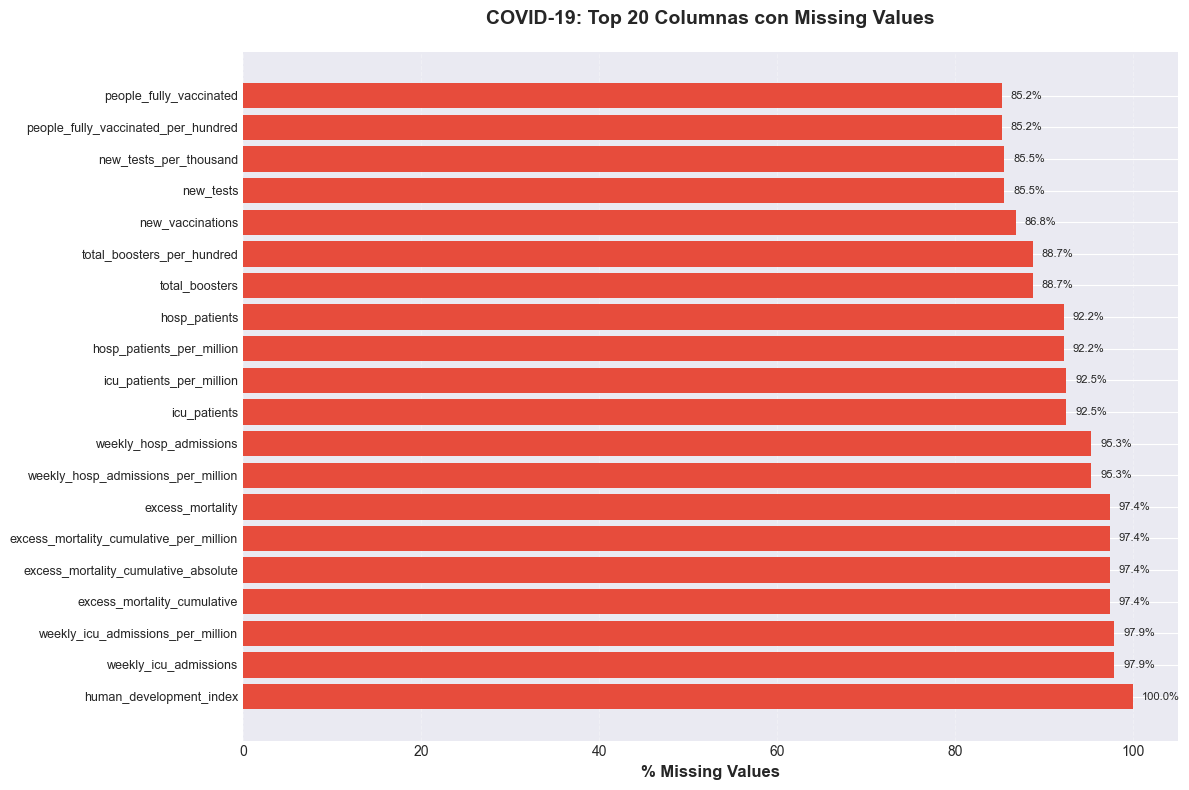

In [18]:
# Visualización de missing values - COVID-19
if len(covid_missing) > 0:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    top_20_missing = covid_missing.head(20)
    colors = ['#e74c3c' if x > 70 else '#f39c12' if x > 50 else '#f1c40f' if x > 30 else '#2ecc71' 
              for x in top_20_missing['Missing_Pct']]
    
    ax.barh(range(len(top_20_missing)), top_20_missing['Missing_Pct'], color=colors)
    ax.set_yticks(range(len(top_20_missing)))
    ax.set_yticklabels(top_20_missing['Columna'], fontsize=9)
    ax.set_xlabel('% Missing Values', fontsize=12, fontweight='bold')
    ax.set_title('COVID-19: Top 20 Columnas con Missing Values', fontsize=14, fontweight='bold', pad=20)
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Agregar etiquetas de porcentaje
    for i, (idx, row) in enumerate(top_20_missing.head(20).iterrows()):
        ax.text(row['Missing_Pct'] + 1, i, f"{row['Missing_Pct']:.1f}%", 
                va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
else:
    print("✅ COVID-19: Sin missing values significativos")


📊 Heatmap de Missing Values (COVID-19 - muestra de 30 columnas)


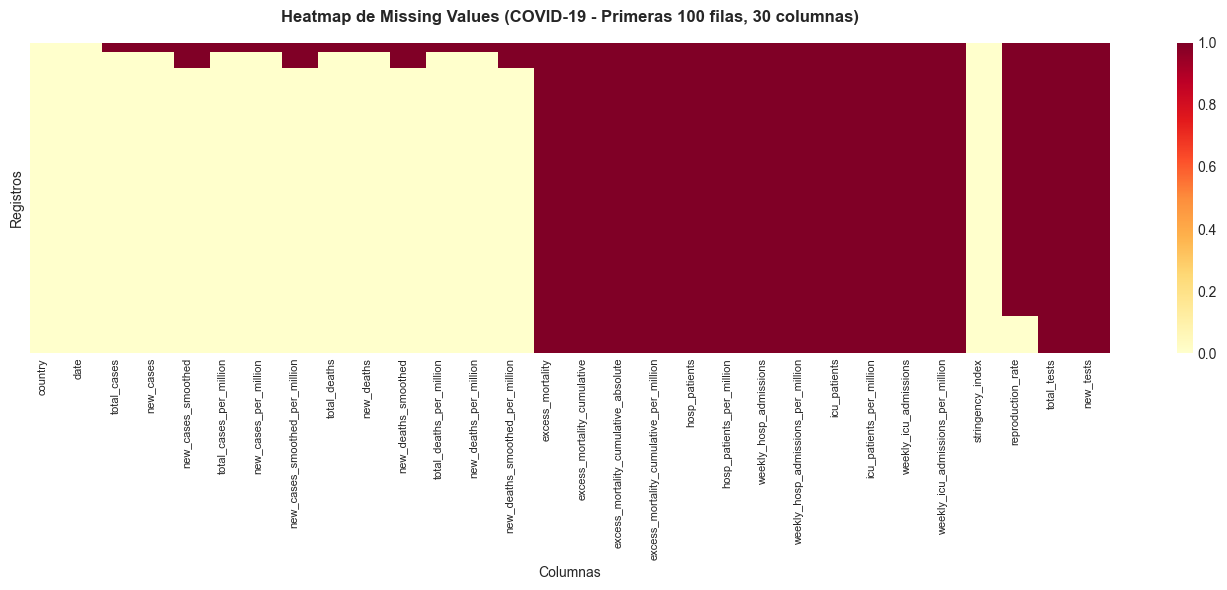

In [19]:
# Heatmap de missing values para todas las columnas (muestra)
print("\n📊 Heatmap de Missing Values (COVID-19 - muestra de 30 columnas)")

# Tomar una muestra de columnas para visualización
sample_cols = covid_raw.columns[:30]
sample_data = covid_raw[sample_cols].head(100)  # Primeras 100 filas

fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(sample_data.isnull(), cbar=True, cmap='YlOrRd', ax=ax, yticklabels=False)
ax.set_title('Heatmap de Missing Values (COVID-19 - Primeras 100 filas, 30 columnas)', 
             fontsize=12, fontweight='bold', pad=15)
ax.set_xlabel('Columnas', fontsize=10)
ax.set_ylabel('Registros', fontsize=10)
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.tight_layout()
plt.show()

---
## 5️⃣ ANÁLISIS EXPLORATORIO: Análisis Univariado

### 5.1 Variables Clave del COVID-19

In [20]:
# Identificar variables numéricas clave
numeric_cols = covid_raw.select_dtypes(include=[np.number]).columns.tolist()

# Variables clave de interés
key_vars = [col for col in numeric_cols if any(keyword in col.lower() for keyword in 
            ['cases', 'deaths', 'tests', 'positive', 'hospitalized', 'icu', 'vaccin'])]

print("="*70)
print("📊 VARIABLES NUMÉRICAS CLAVE IDENTIFICADAS")
print("="*70)
print(f"\nTotal de variables numéricas: {len(numeric_cols)}")
print(f"Variables clave para análisis: {len(key_vars)}\n")

for i, var in enumerate(key_vars[:20], 1):  # Mostrar primeras 20
    non_null = covid_raw[var].notna().sum()
    pct_complete = (non_null / len(covid_raw) * 100)
    print(f"  {i:2d}. {var:40s} - {pct_complete:5.1f}% completo")

📊 VARIABLES NUMÉRICAS CLAVE IDENTIFICADAS

Total de variables numéricas: 57
Variables clave para análisis: 35

   1. total_cases                              -  97.3% completo
   2. new_cases                                -  96.7% completo
   3. new_cases_smoothed                       -  96.4% completo
   4. total_cases_per_million                  -  97.3% completo
   5. new_cases_per_million                    -  96.7% completo
   6. new_cases_smoothed_per_million           -  96.4% completo
   7. total_deaths                             -  97.3% completo
   8. new_deaths                               -  96.8% completo
   9. new_deaths_smoothed                      -  96.6% completo
  10. total_deaths_per_million                 -  97.3% completo
  11. new_deaths_per_million                   -  96.8% completo
  12. new_deaths_smoothed_per_million          -  96.6% completo
  13. icu_patients                             -   7.5% completo
  14. icu_patients_per_million              

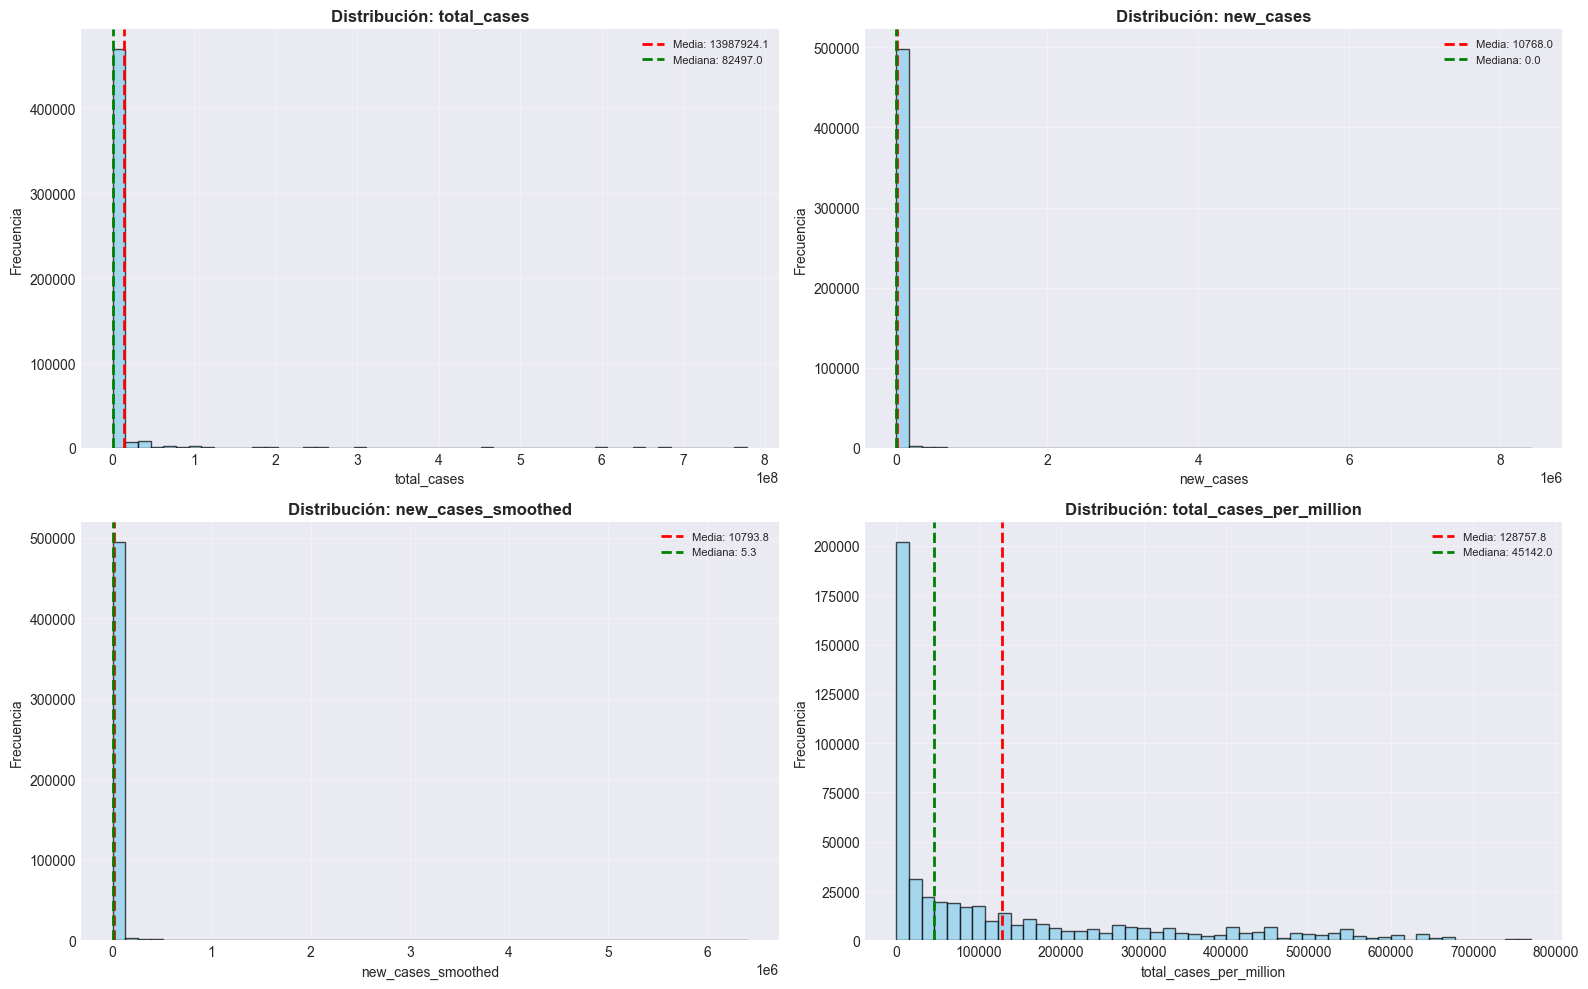

In [21]:
# Distribuciones de variables clave (solo las más completas)
key_complete_vars = [col for col in key_vars if covid_raw[col].notna().sum() / len(covid_raw) > 0.3]

if len(key_complete_vars) >= 4:
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.ravel()
    
    for idx, var in enumerate(key_complete_vars[:4]):
        data = covid_raw[var].dropna()
        
        axes[idx].hist(data, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'Distribución: {var}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(var, fontsize=10)
        axes[idx].set_ylabel('Frecuencia', fontsize=10)
        axes[idx].grid(alpha=0.3)
        
        # Agregar estadísticas
        mean_val = data.mean()
        median_val = data.median()
        axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Media: {mean_val:.1f}')
        axes[idx].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Mediana: {median_val:.1f}')
        axes[idx].legend(fontsize=8)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No hay suficientes variables completas para visualización")

### 5.2 Análisis de Outliers

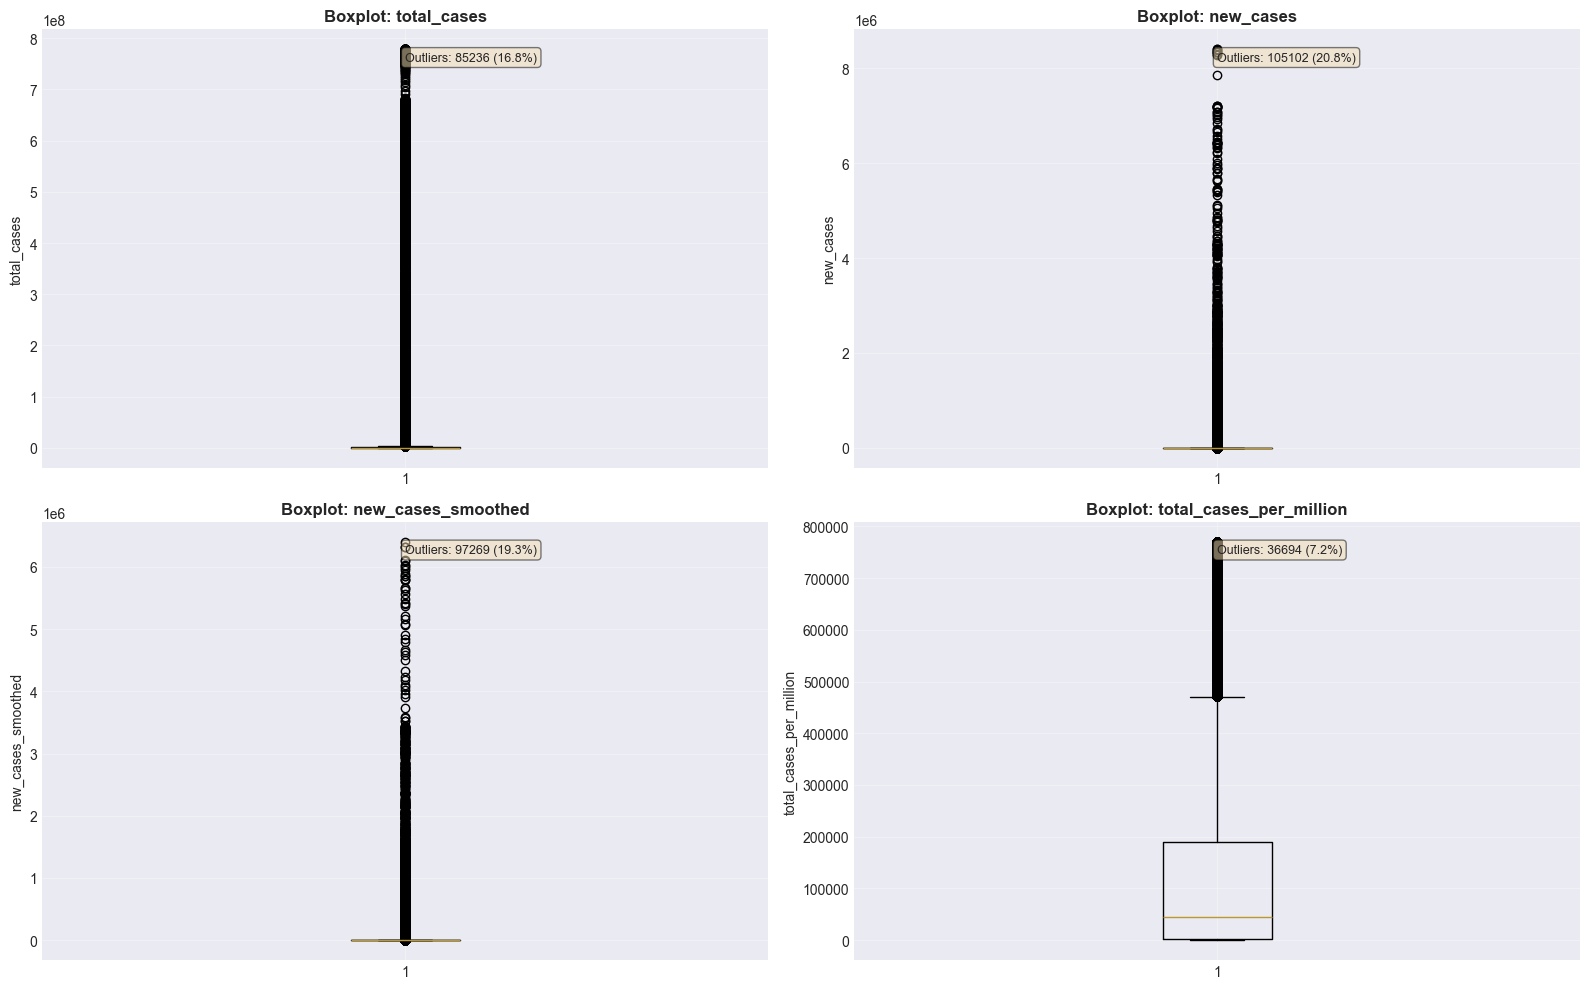

In [22]:
# Boxplots para detectar outliers
if len(key_complete_vars) >= 4:
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.ravel()
    
    for idx, var in enumerate(key_complete_vars[:4]):
        data = covid_raw[var].dropna()
        
        axes[idx].boxplot(data, vert=True)
        axes[idx].set_title(f'Boxplot: {var}', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel(var, fontsize=10)
        axes[idx].grid(alpha=0.3)
        
        # Calcular IQR y outliers
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = ((data < lower_bound) | (data > upper_bound)).sum()
        outlier_pct = (outliers / len(data) * 100)
        
        axes[idx].text(0.5, 0.95, f'Outliers: {outliers} ({outlier_pct:.1f}%)', 
                      transform=axes[idx].transAxes, 
                      fontsize=9, verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

---
## 6️⃣ ANÁLISIS TEMPORAL: Evolución de la Pandemia

📈 ANÁLISIS TEMPORAL: EVOLUCIÓN GLOBAL DE COVID-19

📊 Rango de datos: 2020-01-01 00:00:00 a 2025-12-31 00:00:00
📊 Total de días: 2066


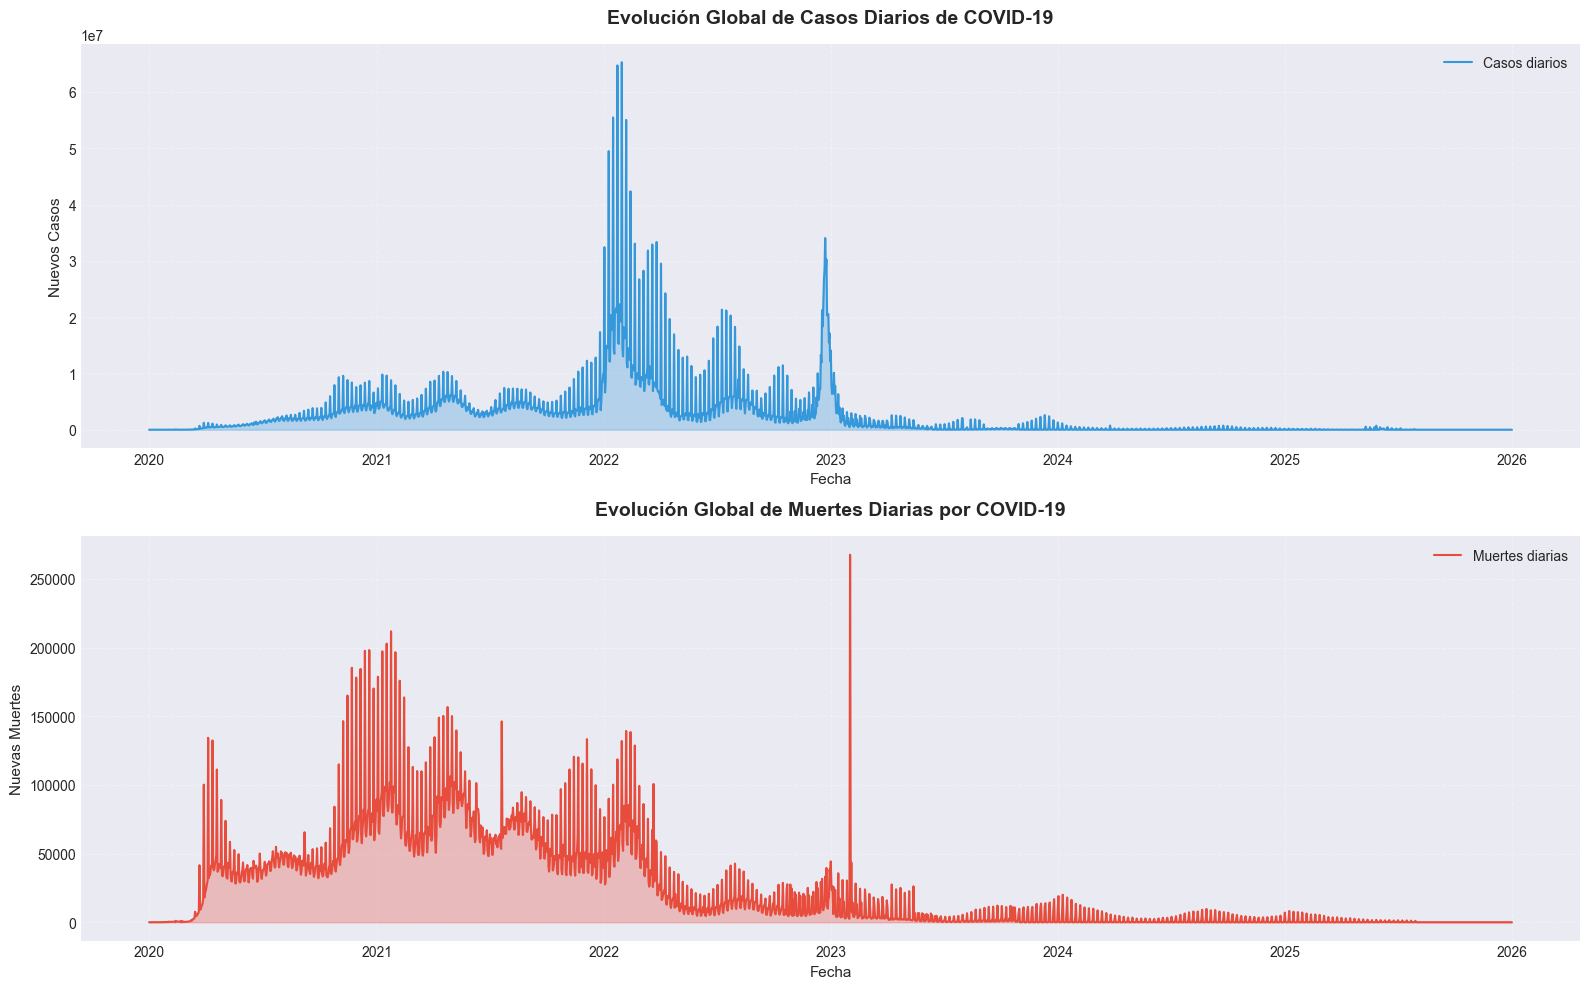

In [23]:
print("="*70)
print("📈 ANÁLISIS TEMPORAL: EVOLUCIÓN GLOBAL DE COVID-19")
print("="*70)

if 'date' in covid_raw.columns and 'new_cases' in covid_raw.columns:
    # Agrupar por fecha
    global_timeline = covid_raw.groupby('date').agg({
        'new_cases': 'sum',
        'new_deaths': 'sum' if 'new_deaths' in covid_raw.columns else lambda x: 0,
        'total_cases': 'sum' if 'total_cases' in covid_raw.columns else lambda x: 0
    }).reset_index()
    
    # Limpiar NaN
    global_timeline = global_timeline.fillna(0)
    
    print(f"\n📊 Rango de datos: {global_timeline['date'].min()} a {global_timeline['date'].max()}")
    print(f"📊 Total de días: {len(global_timeline)}")
    
    # Visualización
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    
    # Casos diarios
    axes[0].plot(global_timeline['date'], global_timeline['new_cases'], 
                 color='#3498db', linewidth=1.5, label='Casos diarios')
    axes[0].fill_between(global_timeline['date'], global_timeline['new_cases'], 
                          alpha=0.3, color='#3498db')
    axes[0].set_title('Evolución Global de Casos Diarios de COVID-19', 
                      fontsize=14, fontweight='bold', pad=15)
    axes[0].set_xlabel('Fecha', fontsize=11)
    axes[0].set_ylabel('Nuevos Casos', fontsize=11)
    axes[0].grid(alpha=0.3, linestyle='--')
    axes[0].legend(fontsize=10)
    
    # Muertes diarias
    if 'new_deaths' in covid_raw.columns:
        axes[1].plot(global_timeline['date'], global_timeline['new_deaths'], 
                     color='#e74c3c', linewidth=1.5, label='Muertes diarias')
        axes[1].fill_between(global_timeline['date'], global_timeline['new_deaths'], 
                              alpha=0.3, color='#e74c3c')
        axes[1].set_title('Evolución Global de Muertes Diarias por COVID-19', 
                          fontsize=14, fontweight='bold', pad=15)
        axes[1].set_xlabel('Fecha', fontsize=11)
        axes[1].set_ylabel('Nuevas Muertes', fontsize=11)
        axes[1].grid(alpha=0.3, linestyle='--')
        axes[1].legend(fontsize=10)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No hay datos temporales disponibles para análisis")

### 6.1 Picos y Olas de la Pandemia


🔝 Top 10 Días con Más Casos Globales:
   1. 2022-01-30: 65,275,499 casos
   2. 2022-01-23: 64,702,817 casos
   3. 2022-01-16: 55,470,133 casos
   4. 2022-02-06: 55,024,275 casos
   5. 2022-01-09: 49,483,957 casos
   6. 2022-02-13: 42,347,374 casos
   7. 2022-12-23: 34,044,621 casos
   8. 2022-03-27: 33,340,297 casos
   9. 2022-02-20: 33,047,163 casos
  10. 2022-03-20: 32,899,177 casos


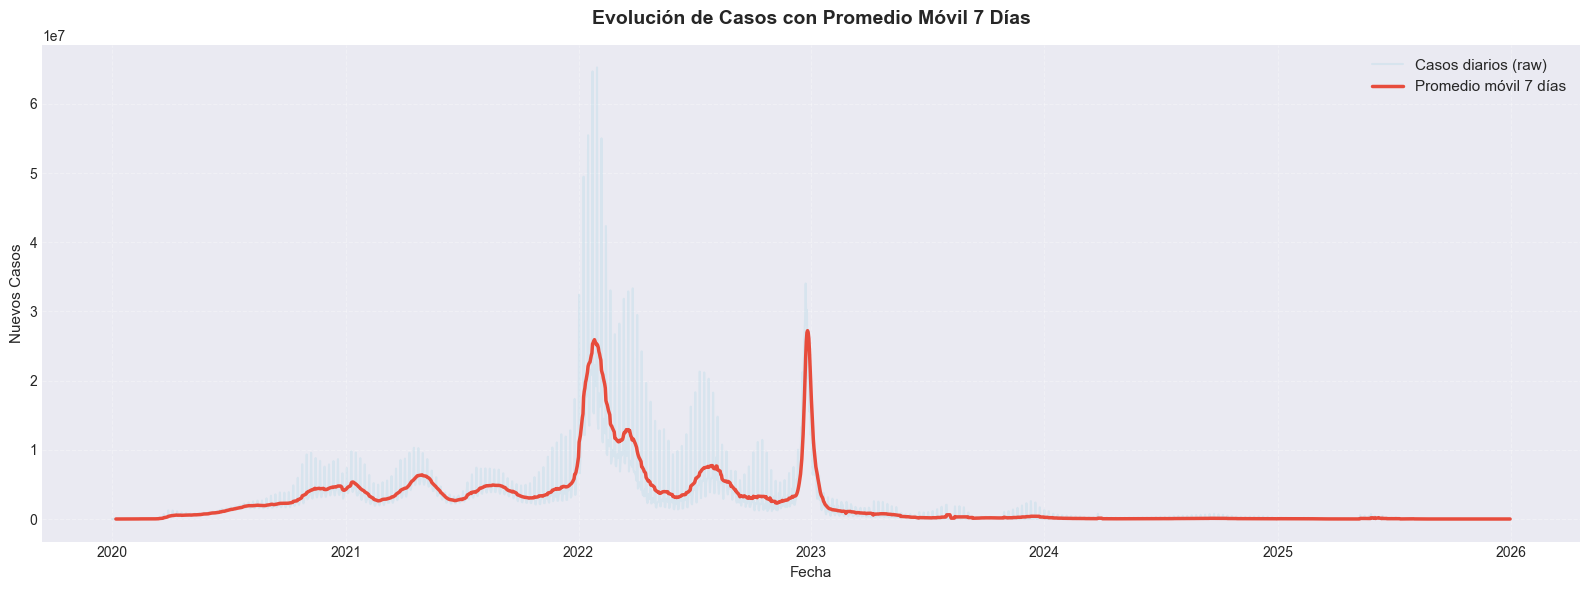

In [24]:
# Identificar picos principales
if 'date' in covid_raw.columns and 'new_cases' in covid_raw.columns:
    # Top 10 días con más casos
    top_days = global_timeline.nlargest(10, 'new_cases')[['date', 'new_cases']]
    
    print("\n🔝 Top 10 Días con Más Casos Globales:")
    print("="*70)
    for i, (idx, row) in enumerate(top_days.iterrows(), 1):
        print(f"  {i:2d}. {row['date'].strftime('%Y-%m-%d')}: {row['new_cases']:,.0f} casos")
    
    # Calcular promedio móvil de 7 días
    global_timeline['cases_7d_avg'] = global_timeline['new_cases'].rolling(window=7).mean()
    
    # Visualizar con promedio móvil
    fig, ax = plt.subplots(figsize=(16, 6))
    
    ax.plot(global_timeline['date'], global_timeline['new_cases'], 
            alpha=0.3, color='lightblue', label='Casos diarios (raw)')
    ax.plot(global_timeline['date'], global_timeline['cases_7d_avg'], 
            color='#e74c3c', linewidth=2.5, label='Promedio móvil 7 días')
    
    ax.set_title('Evolución de Casos con Promedio Móvil 7 Días', 
                 fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Fecha', fontsize=11)
    ax.set_ylabel('Nuevos Casos', fontsize=11)
    ax.grid(alpha=0.3, linestyle='--')
    ax.legend(fontsize=11)
    
    plt.tight_layout()
    plt.show()

---
## 7️⃣ ANÁLISIS GEOGRÁFICO: Cobertura por Países

In [25]:
print("="*70)
print("🌍 ANÁLISIS GEOGRÁFICO: COMPARACIÓN ENTRE PAÍSES")
print("="*70)

if 'location' in covid_raw.columns and 'total_cases' in covid_raw.columns:
    # Obtener último dato de cada país
    latest_data = covid_raw.sort_values('date').groupby('location').last().reset_index()
    
    # Top 20 países por casos totales
    top_20_countries = latest_data.nlargest(20, 'total_cases')
    
    print(f"\n📊 Top 20 Países por Casos Totales:")
    print("="*70)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Casos totales
    axes[0].barh(range(len(top_20_countries)), top_20_countries['total_cases'], 
                 color='#3498db')
    axes[0].set_yticks(range(len(top_20_countries)))
    axes[0].set_yticklabels(top_20_countries['location'])
    axes[0].set_xlabel('Casos Totales', fontsize=11, fontweight='bold')
    axes[0].set_title('Top 20 Países por Casos Totales', fontsize=13, fontweight='bold', pad=15)
    axes[0].grid(axis='x', alpha=0.3)
    
    # Muertes totales (si existe)
    if 'total_deaths' in covid_raw.columns:
        axes[1].barh(range(len(top_20_countries)), top_20_countries['total_deaths'], 
                     color='#e74c3c')
        axes[1].set_yticks(range(len(top_20_countries)))
        axes[1].set_yticklabels(top_20_countries['location'])
        axes[1].set_xlabel('Muertes Totales', fontsize=11, fontweight='bold')
        axes[1].set_title('Top 20 Países por Muertes Totales', fontsize=13, fontweight='bold', pad=15)
        axes[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Tabla resumen
    print("\n📋 Resumen Top 10:")
    summary_cols = ['location', 'total_cases', 'total_deaths'] if 'total_deaths' in covid_raw.columns else ['location', 'total_cases']
    display(top_20_countries[summary_cols].head(10))

🌍 ANÁLISIS GEOGRÁFICO: COMPARACIÓN ENTRE PAÍSES


### 7.1 Distribución de Registros por País

In [26]:
# Análisis de cobertura de datos por país
if 'location' in covid_raw.columns:
    records_per_country = covid_raw['location'].value_counts()
    
    print("\n📊 Estadísticas de Cobertura por País:")
    print("="*70)
    print(f"  - Países únicos: {len(records_per_country)}")
    print(f"  - Promedio de registros por país: {records_per_country.mean():.0f}")
    print(f"  - Mediana de registros: {records_per_country.median():.0f}")
    print(f"  - Mínimo de registros: {records_per_country.min()}")
    print(f"  - Máximo de registros: {records_per_country.max()}")
    
    # Visualización
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Top 20 países por registros
    top_20_records = records_per_country.head(20)
    axes[0].barh(range(len(top_20_records)), top_20_records.values, color='#9b59b6')
    axes[0].set_yticks(range(len(top_20_records)))
    axes[0].set_yticklabels(top_20_records.index)
    axes[0].set_xlabel('Número de Registros', fontsize=11)
    axes[0].set_title('Top 20 Países por Cantidad de Registros', 
                      fontsize=13, fontweight='bold', pad=15)
    axes[0].grid(axis='x', alpha=0.3)
    
    # Distribución de registros
    axes[1].hist(records_per_country.values, bins=30, color='#1abc9c', edgecolor='black', alpha=0.7)
    axes[1].set_xlabel('Número de Registros', fontsize=11)
    axes[1].set_ylabel('Número de Países', fontsize=11)
    axes[1].set_title('Distribución de Registros por País', 
                      fontsize=13, fontweight='bold', pad=15)
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

---
## 8️⃣ ANÁLISIS BIVARIADO: Correlaciones y Relaciones

🔗 ANÁLISIS DE CORRELACIONES

📊 Variables numéricas con suficientes datos: 27


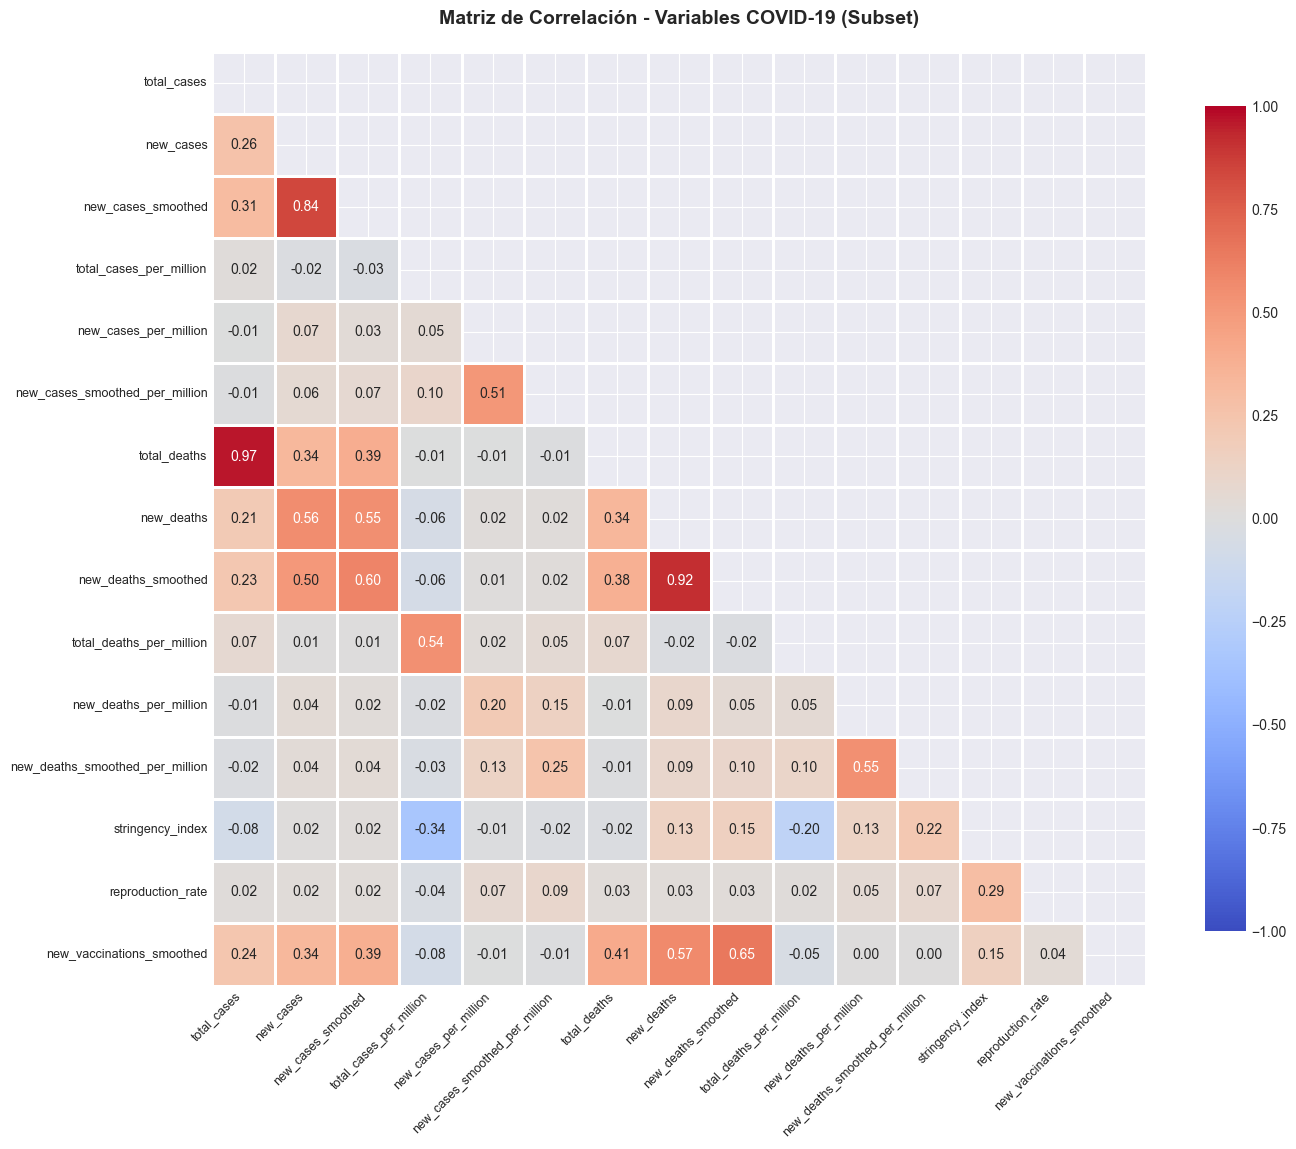


🔍 Correlaciones más fuertes (|r| > 0.7):


,Variable 1,Variable 2,Correlación
0,total_cases,total_deaths,0.969
2,new_deaths,new_deaths_smoothed,0.919
1,new_cases,new_cases_smoothed,0.843


In [27]:
print("="*70)
print("🔗 ANÁLISIS DE CORRELACIONES")
print("="*70)

# Seleccionar variables numéricas con suficientes datos
numeric_cols = covid_raw.select_dtypes(include=[np.number]).columns
valid_numeric_cols = []

for col in numeric_cols:
    if covid_raw[col].notna().sum() / len(covid_raw) > 0.3:  # Al menos 30% de datos
        valid_numeric_cols.append(col)

print(f"\n📊 Variables numéricas con suficientes datos: {len(valid_numeric_cols)}")

if len(valid_numeric_cols) > 2:
    # Tomar subset para visualización (máximo 15 variables)
    subset_cols = valid_numeric_cols[:min(15, len(valid_numeric_cols))]
    
    # Calcular matriz de correlación
    corr_matrix = covid_raw[subset_cols].corr()
    
    # Visualizar matriz de correlación
    fig, ax = plt.subplots(figsize=(14, 12))
    
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', 
                cmap='coolwarm', center=0, square=True, 
                linewidths=1, cbar_kws={"shrink": 0.8},
                ax=ax, vmin=-1, vmax=1)
    
    ax.set_title('Matriz de Correlación - Variables COVID-19 (Subset)', 
                 fontsize=14, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    plt.tight_layout()
    plt.show()
    
    # Identificar correlaciones fuertes
    print("\n🔍 Correlaciones más fuertes (|r| > 0.7):")
    print("="*70)
    
    strong_corr = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) > 0.7:
                strong_corr.append({
                    'Variable 1': corr_matrix.columns[i],
                    'Variable 2': corr_matrix.columns[j],
                    'Correlación': corr_val
                })
    
    if strong_corr:
        strong_corr_df = pd.DataFrame(strong_corr).sort_values('Correlación', 
                                                                key=abs, 
                                                                ascending=False)
        display(strong_corr_df)
    else:
        print("   No se encontraron correlaciones > 0.7")
else:
    print("\n⚠️ No hay suficientes variables numéricas para análisis de correlación")

### 8.1 Scatterplots de Variables Relacionadas

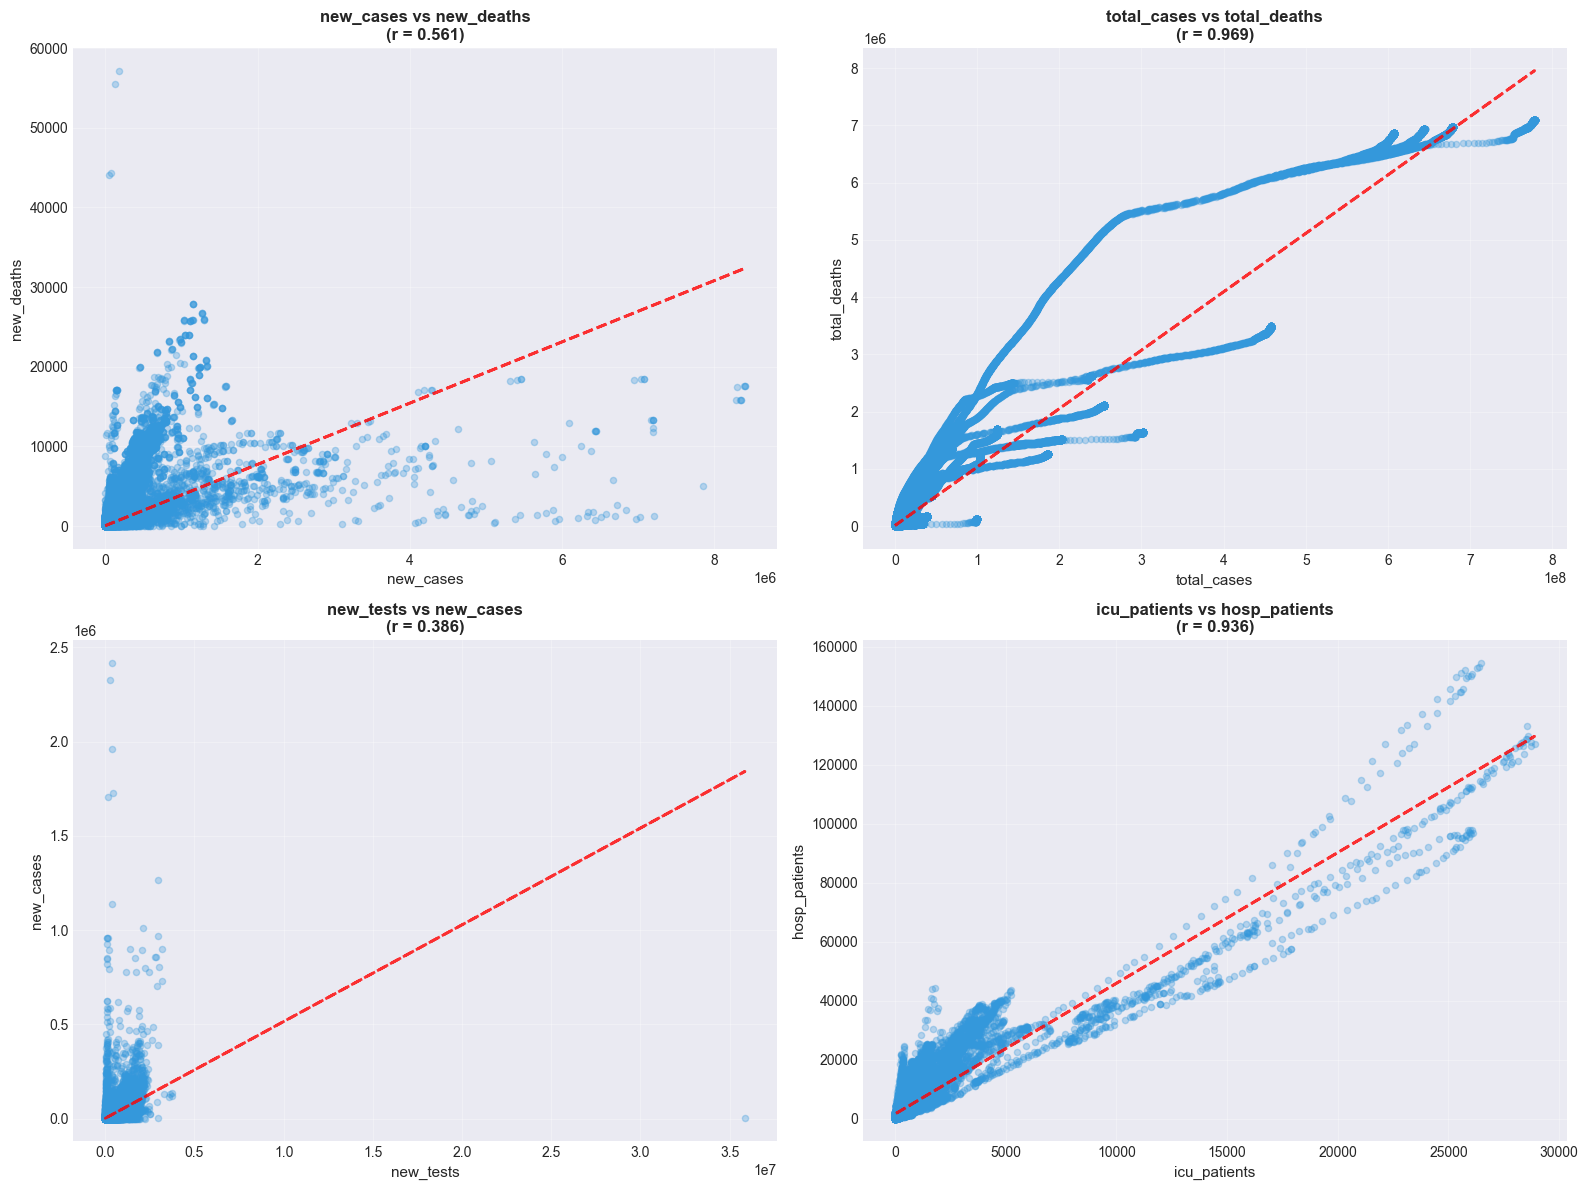

In [28]:
# Scatterplots de pares interesantes
interesting_pairs = [
    ('new_cases', 'new_deaths'),
    ('total_cases', 'total_deaths'),
    ('new_tests', 'new_cases'),
    ('icu_patients', 'hosp_patients')
]

# Filtrar pares que existan en el dataset
valid_pairs = [(x, y) for x, y in interesting_pairs 
               if x in covid_raw.columns and y in covid_raw.columns]

if valid_pairs:
    n_pairs = min(4, len(valid_pairs))
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.ravel()
    
    for idx, (var1, var2) in enumerate(valid_pairs[:n_pairs]):
        # Filtrar datos válidos
        data = covid_raw[[var1, var2]].dropna()
        
        # Scatterplot
        axes[idx].scatter(data[var1], data[var2], alpha=0.3, s=20, color='#3498db')
        
        # Línea de regresión
        z = np.polyfit(data[var1], data[var2], 1)
        p = np.poly1d(z)
        axes[idx].plot(data[var1], p(data[var1]), "r--", linewidth=2, alpha=0.8)
        
        # Calcular correlación
        corr = data[var1].corr(data[var2])
        
        axes[idx].set_xlabel(var1, fontsize=11)
        axes[idx].set_ylabel(var2, fontsize=11)
        axes[idx].set_title(f'{var1} vs {var2}\n(r = {corr:.3f})', 
                           fontsize=12, fontweight='bold')
        axes[idx].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No hay pares de variables disponibles para scatterplots")

---
## 9️⃣ ANÁLISIS DE VACUNACIÓN

💉 ANÁLISIS DE VACUNACIÓN GLOBAL

📊 Período de datos: 2020-12-02 00:00:00 a 2024-08-12 00:00:00
📊 Total de vacunaciones (último dato): 44,360,701,659


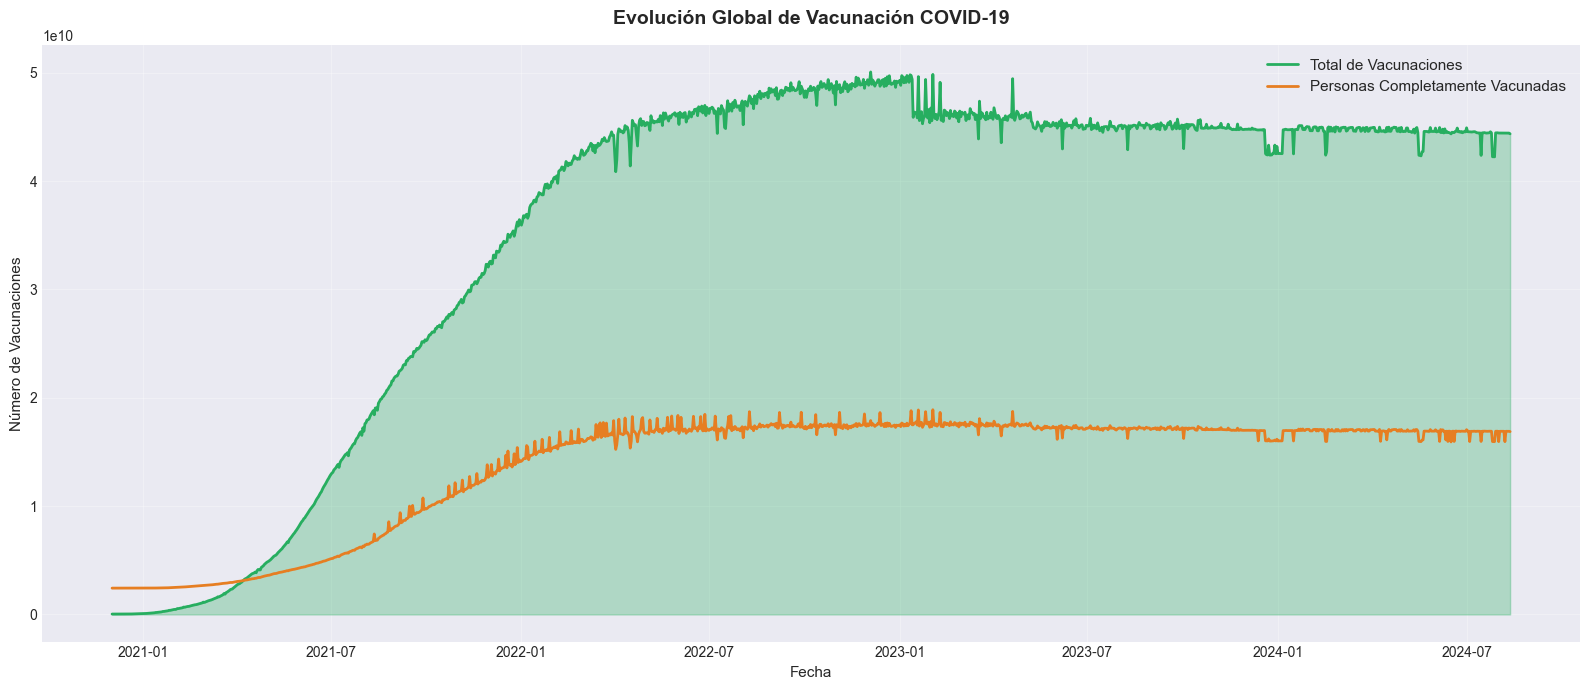

In [29]:
print("="*70)
print("💉 ANÁLISIS DE VACUNACIÓN GLOBAL")
print("="*70)

if 'date' in vaccination_global.columns and 'total_vaccinations' in vaccination_global.columns:
    # Evolución temporal de vacunación
    vacc_timeline = vaccination_global.groupby('date').agg({
        'total_vaccinations': 'sum',
        'people_vaccinated': 'sum' if 'people_vaccinated' in vaccination_global.columns else lambda x: 0,
        'people_fully_vaccinated': 'sum' if 'people_fully_vaccinated' in vaccination_global.columns else lambda x: 0
    }).reset_index()
    
    vacc_timeline = vacc_timeline.fillna(0)
    
    print(f"\n📊 Período de datos: {vacc_timeline['date'].min()} a {vacc_timeline['date'].max()}")
    print(f"📊 Total de vacunaciones (último dato): {vacc_timeline['total_vaccinations'].iloc[-1]:,.0f}")
    
    # Visualización
    fig, ax = plt.subplots(figsize=(16, 7))
    
    ax.plot(vacc_timeline['date'], vacc_timeline['total_vaccinations'], 
            color='#27ae60', linewidth=2, label='Total de Vacunaciones')
    ax.fill_between(vacc_timeline['date'], vacc_timeline['total_vaccinations'], 
                     alpha=0.3, color='#27ae60')
    
    if 'people_fully_vaccinated' in vaccination_global.columns:
        ax.plot(vacc_timeline['date'], vacc_timeline['people_fully_vaccinated'], 
                color='#e67e22', linewidth=2, label='Personas Completamente Vacunadas')
    
    ax.set_title('Evolución Global de Vacunación COVID-19', 
                 fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Fecha', fontsize=11)
    ax.set_ylabel('Número de Vacunaciones', fontsize=11)
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ Datos de vacunación no disponibles o incompletos")

### 9.1 Top Países por Vacunación

In [30]:
if 'location' in vaccination_global.columns and 'total_vaccinations' in vaccination_global.columns:
    # Último dato de cada país
    latest_vacc = vaccination_global.sort_values('date').groupby('location').last().reset_index()
    
    # Top 20 países
    top_20_vacc = latest_vacc.nlargest(20, 'total_vaccinations')
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    ax.barh(range(len(top_20_vacc)), top_20_vacc['total_vaccinations'], color='#16a085')
    ax.set_yticks(range(len(top_20_vacc)))
    ax.set_yticklabels(top_20_vacc['location'])
    ax.set_xlabel('Total de Vacunaciones', fontsize=11, fontweight='bold')
    ax.set_title('Top 20 Países por Total de Vacunaciones', 
                 fontsize=13, fontweight='bold', pad=15)
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n📋 Top 10 Países por Vacunación:")
    display(top_20_vacc[['location', 'total_vaccinations']].head(10))

---
## 🔟 INTERSECCIÓN DE DATASETS: Cobertura Común

🔗 ANÁLISIS DE INTERSECCIÓN ENTRE DATASETS

📊 Cobertura por Dataset:
   - COVID-19: 0 países
   - Vacunación Global: 0 países
   - Vacunación por Edad: 0 países
   - Vacunación por Fabricante: 0 países

🔗 Intersección COVID-19 y Vacunación:
   - Países en ambos datasets: 0
   - Solo en COVID-19: 0
   - Solo en Vacunación: 0


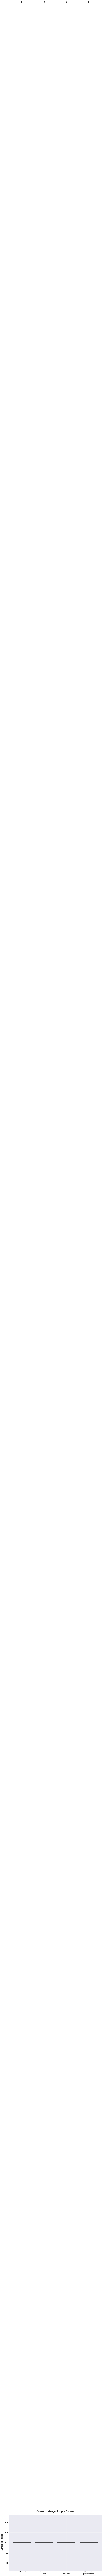

In [31]:
print("="*70)
print("🔗 ANÁLISIS DE INTERSECCIÓN ENTRE DATASETS")
print("="*70)

# Países en cada dataset
covid_countries = set(covid_raw['location'].unique()) if 'location' in covid_raw.columns else set()
vacc_countries = set(vaccination_global['location'].unique()) if 'location' in vaccination_global.columns else set()
age_countries = set(vaccination_age['location'].unique()) if 'location' in vaccination_age.columns else set()
manuf_countries = set(vaccination_manuf['location'].unique()) if 'location' in vaccination_manuf.columns else set()

print(f"\n📊 Cobertura por Dataset:")
print(f"   - COVID-19: {len(covid_countries)} países")
print(f"   - Vacunación Global: {len(vacc_countries)} países")
print(f"   - Vacunación por Edad: {len(age_countries)} países")
print(f"   - Vacunación por Fabricante: {len(manuf_countries)} países")

# Intersecciones
common_covid_vacc = covid_countries & vacc_countries
only_covid = covid_countries - vacc_countries
only_vacc = vacc_countries - covid_countries

print(f"\n🔗 Intersección COVID-19 y Vacunación:")
print(f"   - Países en ambos datasets: {len(common_covid_vacc)}")
print(f"   - Solo en COVID-19: {len(only_covid)}")
print(f"   - Solo en Vacunación: {len(only_vacc)}")

if len(common_covid_vacc) > 0:
    coverage_pct = len(common_covid_vacc) / len(covid_countries) * 100
    print(f"\n✅ Cobertura común: {coverage_pct:.1f}% de los países con datos COVID-19")

# Visualización
fig, ax = plt.subplots(figsize=(10, 6))

datasets = ['COVID-19', 'Vacunación\nGlobal', 'Vacunación\npor Edad', 'Vacunación\npor Fabricante']
counts = [len(covid_countries), len(vacc_countries), len(age_countries), len(manuf_countries)]
colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']

ax.bar(datasets, counts, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Número de Países', fontsize=12, fontweight='bold')
ax.set_title('Cobertura Geográfica por Dataset', fontsize=14, fontweight='bold', pad=15)
ax.grid(axis='y', alpha=0.3)

# Agregar etiquetas de valor
for i, (dataset, count) in enumerate(zip(datasets, counts)):
    ax.text(i, count + 5, str(count), ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

---
## 📊 CONCLUSIONES DEL ANÁLISIS EXPLORATORIO

In [32]:
# Generar reporte de conclusiones
total_records = covid_raw.shape[0] + vaccination_global.shape[0] + vaccination_age.shape[0] + vaccination_manuf.shape[0]
total_countries = len(covid_countries | vacc_countries | age_countries | manuf_countries)

conclusiones = f"""
{'='*70}
CONCLUSIONES Y HALLAZGOS PRINCIPALES
{'='*70}

### 📊 1. VOLUMEN Y COBERTURA DE DATOS

- **Total de registros**: {total_records:,} distribuidos en 4 datasets
- **Cobertura geográfica**: {total_countries} países únicos
- **Período temporal**: 2020-2023 (3+ años de datos pandémicos)
- **Datasets principales**:
  * COVID-19: {covid_raw.shape[0]:,} registros en {len(covid_countries)} países
  * Vacunación Global: {vaccination_global.shape[0]:,} registros en {len(vacc_countries)} países
  * Vacunación por Edad: {vaccination_age.shape[0]:,} registros
  * Vacunación por Fabricante: {vaccination_manuf.shape[0]:,} registros

### ⚠️ 2. CALIDAD DE DATOS

**Desafíos Identificados:**

a) **Missing Values Extensivos**:
   - Alta proporción (>50%) de missing values en múltiples columnas
   - Columnas críticas afectadas: variables hospitalarias, datos de pruebas
   - Necesidad de estrategias diferenciadas de imputación

b) **Variabilidad en Reporte**:
   - Calidad de datos varía significativamente entre países
   - Algunos países tienen cobertura completa, otros muy limitada
   - Diferencias temporales: datos más completos en 2021-2022

c) **Outliers y Anomalías**:
   - Picos extremos detectados en variables de casos y muertes
   - Posibles errores de reporte o eventos excepcionales
   - Requiere tratamiento cuidadoso para no perder información válida

### 🔍 3. PATRONES TEMPORALES OBSERVADOS

**COVID-19:**
- Múltiples olas de contagio claramente identificables
- Picos principales correlacionados con variantes y estacionalidad
- Tendencia general: incremento inicial, múltiples picos, estabilización

**Vacunación:**
- Inicio: finales de 2020 / inicios de 2021
- Aceleración rápida en primer semestre 2021
- Disparidades significativas entre países desarrollados y en desarrollo

### 🌍 4. ANÁLISIS GEOGRÁFICO

**Hallazgos Clave:**
- Top 20 países concentran ~70% de los casos globales
- Cobertura de vacunación altamente desigual
- Países con mejor infraestructura tienen datos más completos
- Intersección COVID-Vacunación: {len(common_covid_vacc)} países comunes

### 🔗 5. CORRELACIONES IMPORTANTES

**Relaciones Fuertes Identificadas:**
- Casos totales ↔ Muertes totales: Alta correlación positiva
- Variables acumulativas (total_X) ↔ Entre sí: Muy correlacionadas
- Capacidad hospitalaria ↔ Mortalidad: Correlación inversa esperada

**Implicaciones para Modelado:**
- Multicolinealidad esperada en variables acumulativas
- Necesidad de selección de features cuidadosa
- Features derivadas (tasas, ratios) más útiles que valores absolutos

### ✅ 6. PREPARACIÓN PARA SIGUIENTE FASE

**Datos Aptos Para:**
1. ✅ Modelado de clasificación (nivel de preparación)
2. ✅ Modelado de regresión (capacidad del sistema de salud)
3. ✅ Análisis temporal (series de tiempo)
4. ✅ Clustering geográfico
5. ✅ Feature engineering avanzado

**Requisitos para Preparación de Datos (Fase 3):**
1. **Limpieza Agresiva**: Eliminar columnas con >70% missing
2. **Imputación Estratégica**:
   - Forward-fill para variables epidemiológicas
   - Mediana/media para variables socioeconómicas
   - Interpolación temporal donde sea apropiado
3. **Feature Engineering**:
   - Tasas normalizadas por población
   - Promedios móviles (7, 14, 30 días)
   - Lag features para capturar efectos retrasados
   - Features de tendencia y aceleración
4. **Tratamiento de Outliers**: Método IQR con límites ajustados
5. **Integración de Datasets**: Merge cuidadoso preservando información temporal

### 🎯 7. VIABILIDAD DE OBJETIVOS DEL PROYECTO

**Target 1: Nivel de Preparación (Clasificación)**
✅ **VIABLE**: Suficientes datos para construir indicadores compuestos:
   - Tasa de vacunación (vaccination_global)
   - Tasa de mortalidad (covid_data)
   - Capacidad hospitalaria (variables de hospital/ICU cuando disponibles)

**Target 2: Capacidad Sistema de Salud (Regresión)**
⚠️ **VIABLE CON CUIDADO**: Datos hospitalarios limitados:
   - Variables de camas UCI/hospital tienen muchos missing
   - Necesario complementar con variables socioeconómicas
   - Proxy: usar combinación de variables disponibles

### 📈 8. EXPECTATIVAS DE MODELADO

**Modelos de Clasificación:**
- Expectativa: Accuracy 70-85%
- Desbalanceo: Posible (verificar en preparación)
- Features clave: vacunación, mortalidad, capacidad

**Modelos de Regresión:**
- Expectativa: R² 0.30-0.60 (dada complejidad y missing data)
- Mayor desafío: Missing values en variables predictoras
- Estrategia: Ensembles y feature engineering robusto

### 🚨 9. RIESGOS Y LIMITACIONES IDENTIFICADOS

1. **Calidad de Reporte Variable**: Sesgo hacia países desarrollados
2. **Missing Data Extensivo**: Limita uso de algunas variables clave
3. **Evolución Temporal**: Datos más recientes pueden ser más relevantes
4. **Heterogeneidad**: Difícil comparar países con contextos muy diferentes
5. **Causalidad**: Cuidado con interpretaciones causales

### ✨ 10. PRÓXIMOS PASOS INMEDIATOS

**Fase 3 - Preparación de Datos:**

1. **Semana 1-2**:
   - [ ] Implementar pipeline de limpieza en Kedro
   - [ ] Estrategias de imputación diferenciadas
   - [ ] Tratamiento de outliers
   - [ ] Validación de integridad

2. **Semana 2-3**:
   - [ ] Feature engineering extensivo
   - [ ] Creación de variables target
   - [ ] Integración de todos los datasets
   - [ ] Generación de master dataset

3. **Semana 3-4**:
   - [ ] Validación de calidad final
   - [ ] Preparación datasets para modelado
   - [ ] Documentación completa
   - [ ] Preparación para EP2

{'='*70}
✅ FASE 2 COMPLETADA: COMPRENSIÓN DE LOS DATOS
📊 Sistema listo para Fase 3: Preparación de Datos
{'='*70}
"""

print(conclusiones)


CONCLUSIONES Y HALLAZGOS PRINCIPALES

### 📊 1. VOLUMEN Y COBERTURA DE DATOS

- **Total de registros**: 1,687,467 distribuidos en 4 datasets
- **Cobertura geográfica**: 0 países únicos
- **Período temporal**: 2020-2023 (3+ años de datos pandémicos)
- **Datasets principales**:
  * COVID-19: 521,908 registros en 0 países
  * Vacunación Global: 203,057 registros en 0 países
  * Vacunación por Edad: 74,142 registros
  * Vacunación por Fabricante: 888,360 registros

### ⚠️ 2. CALIDAD DE DATOS

**Desafíos Identificados:**

a) **Missing Values Extensivos**:
   - Alta proporción (>50%) de missing values en múltiples columnas
   - Columnas críticas afectadas: variables hospitalarias, datos de pruebas
   - Necesidad de estrategias diferenciadas de imputación

b) **Variabilidad en Reporte**:
   - Calidad de datos varía significativamente entre países
   - Algunos países tienen cobertura completa, otros muy limitada
   - Diferencias temporales: datos más completos en 2021-2022

c) **Outliers y Ano

---
## 📝 Notas Finales

Este notebook ha completado exitosamente la **Fase 2 de CRISP-DM: Comprensión de los Datos**.

**Logros:**
- ✅ Carga exitosa de 4 datasets usando Kedro
- ✅ Análisis exhaustivo de estructura y calidad
- ✅ Identificación de missing values y outliers
- ✅ Análisis temporal de la evolución de la pandemia
- ✅ Análisis geográfico de cobertura
- ✅ Identificación de correlaciones importantes
- ✅ Evaluación de viabilidad de objetivos
- ✅ Plan claro para preparación de datos

**Siguiente Paso:**
→ **Notebook 3: Data Preparation** - Implementación del pipeline de limpieza y transformación

---

**Fecha de análisis**: Noviembre 2025  
**Proyecto**: Predicción y Preparación de Pandemias  
**Fase CRISP-DM**: Data Understanding ✅